###In this notebook we see how well we can reproduce Kd from simulated experimental data.

In this notebook we play with data generated in the 'Just Modeling - Single Site Binding Model' notebook, and see how our bayesian models do at reproducing the Kd.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


###The setup.

We use the same setup here as we did in 'Just Modeling - Single Site Binding Model'.

Experimentally we won't know the Kd, but we know the P, PL, and L concentrations. Here PL is copy and pasted from the previous notebook, as it was calculated using the two_component_binding function, when Kd was 2 nM.

In [2]:
Ptot = 1e-9

In [47]:
Ltot = 20.0e-6 / np.array([10**(float(i)/2.0) for i in range(24)]) 

In [4]:
PL = [9.99900005e-10,  9.99683822e-10 ,  9.99000500e-10 ,  9.96842730e-10,
   9.90050244e-10,  9.68884511e-10 ,  9.05189950e-10 ,  7.36430279e-10,
   4.38447187e-10,  1.83368995e-10 ,  6.37708504e-11 ,  2.07876510e-11,
   6.63710303e-12,  2.10522423e-12 ,  6.66370436e-13 ,  2.10788883e-13,
   6.66637038e-14,  2.10815548e-14 ,  6.66663704e-15 ,  2.10818214e-15,
   6.66666370e-16,  2.10818481e-16 ,  6.66666637e-17 ,  2.10818508e-17]

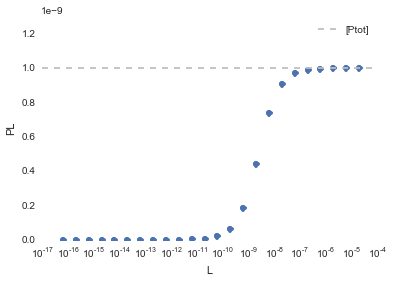

In [5]:
# y will be complex concentration
# x will be total ligand concentration
plt.semilogx(Ltot,PL, 'o')
plt.xlabel('L')
plt.ylabel('PL')
plt.ylim(0,1.3e-9)
plt.axhline(Ptot,color='0.75',linestyle='--',label='[Ptot]')
plt.legend()

###Now make this a fluorescence experiment.

In [6]:
# Making max 400 relative fluorescence units, and scaling all of PL to that
F_i = np.ones([24],np.float64)*(400/1e-9)*PL
Pstated = np.ones([24],np.float64)*Ptot
Lstated = np.ones([24],np.float64)*Ltot

In [7]:
# Uncertainties in protein and ligand concentrations.
dPstated = 0.10 * Pstated # protein concentration uncertainty
dLstated = 0.08 * Lstated # ligand concentraiton uncertainty (due to gravimetric preparation and HP D300 dispensing)

###The test.

In [8]:
# Define our two-component binding system again.
def two_component_binding(DeltaG, P, L):
    Kd = np.exp(DeltaG)
    PL = 0.5 * ((P + L + Kd) - np.sqrt((P + L + Kd)**2 - 4*P*L));  # complex concentration (M)                                                                                                                                                                                                         
    P = P - PL; # free protein concentration in sample cell after n injections (M)                                                                                                                                                                                                                          
    L = L - PL; # free ligand concentration in sample cell after n injections (M)                                                                                                                                                                                                                           
    return [P, L, PL]

In [9]:
# Create a pymc model
def make_model(Pstated, dPstated, Lstated, dLstated, Fobs_i):
    N = len(Lstated)
    # Prior on binding free energies.
    DeltaG = pymc.Uniform('DeltaG', lower=-40, upper=+40, value=0.0) # binding free energy (kT), uniform over huge range
        
    # Priors on true concentrations of protein and ligand.
    Ptrue = pymc.Normal('Ptrue', mu=Pstated, tau=dPstated**(-2)) # protein concentration (M)
    Ltrue = pymc.Normal('Ltrue', mu=Lstated, tau=dLstated**(-2)) # ligand concentration (M)
    Ltrue_control = pymc.Normal('Ltrue_control', mu=Lstated, tau=dLstated**(-2)) # ligand concentration (M)

    # Priors on fluorescence intensities of complexes (later divided by a factor of Pstated for scale).
    Fmax = Fobs_i.max()
    F_background = pymc.Uniform('F_background', lower=0.0, upper=Fmax) # background 
    F_PL = pymc.Uniform('F_PL', lower=0.0, upper=Fmax/min(Pstated.max(),Lstated.max())) # complex fluorescence
    F_L = pymc.Uniform('F_L', lower=0.0, upper=Fmax/Lstated.max()) # ligand fluorescence

    # Unknown experimental measurement error.
    log_sigma = pymc.Uniform('log_sigma', lower=-10, upper=+2, value=0.0) 
    @pymc.deterministic
    def precision(log_sigma=log_sigma): # measurement precision
        return 1.0 / np.exp(log_sigma)**2

    # Fluorescence model.
    @pymc.deterministic
    def Fmodel(F_background=F_background, F_PL=F_PL, F_L=F_L, Ptrue=Ptrue, Ltrue=Ltrue, DeltaG=DeltaG):
        Fmodel_i = np.zeros([N])
        for i in range(N):
            [P, L, PL] = two_component_binding(DeltaG, Ptrue[i], Ltrue[i])
            Fmodel_i[i] = (F_PL*PL + F_L*L) + F_background
        return Fmodel_i
    
    # Experimental error on fluorescence observations.
    Fobs_model = pymc.Normal('Fobs_i', mu=Fmodel, tau=precision, size=[N], observed=True, value=Fobs_i) # observed data
    
    # Construct dictionary of model variables.
    pymc_model = { 'Ptrue' : Ptrue, 
                   'Ltrue' : Ltrue, 
                   'Ltrue_control' : Ltrue_control, 
                   'log_sigma' : log_sigma, 
                   'precision' : precision, 
                   'F_PL' : F_PL, 
                   'F_L' : F_L, 
                   'F_background' : F_background,
                   'Fmodel_i' : Fmodel,
                   'Fobs_model' : Fobs_model, 
                   'DeltaG' : DeltaG # binding free energy
                   }
    return pymc_model

In [10]:
# Build model.
pymc_model = pymc.Model(make_model(Pstated, dPstated, Lstated, dLstated, F_i))

# Sample with MCMC
mcmc = pymc.MCMC(pymc_model, db='ram', name='Sampler', verbose=True)
mcmc.sample(iter=100000, burn=10000, thin=50, progress_bar=False)

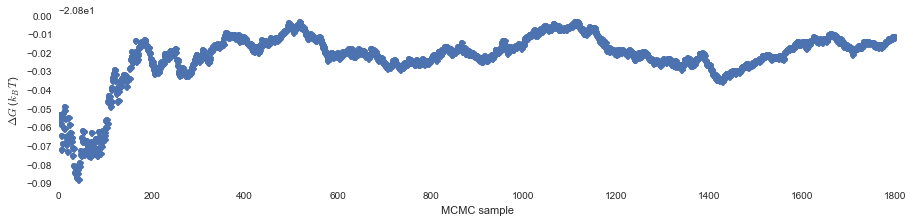

In [11]:
# Plot trace of DeltaG.
rcParams['figure.figsize'] = [15, 3]
plot(mcmc.DeltaG.trace(), 'o');
xlabel('MCMC sample');
ylabel('$\Delta G$ ($k_B T$)');

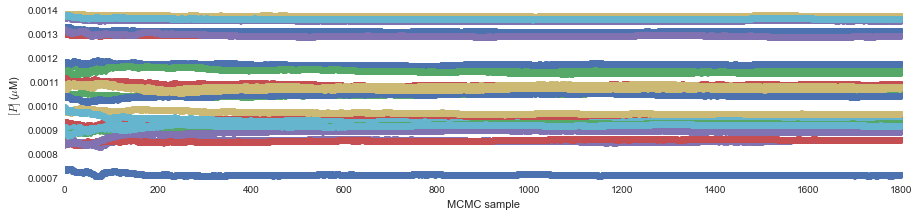

In [12]:
# Plot trace of true protein concentration.
rcParams['figure.figsize'] = [15, 3]
plot(mcmc.Ptrue.trace()*1e6, 'o');
xlabel('MCMC sample');
ylabel('$[P]$ ($\mu$M)');

6.0469749317e-17


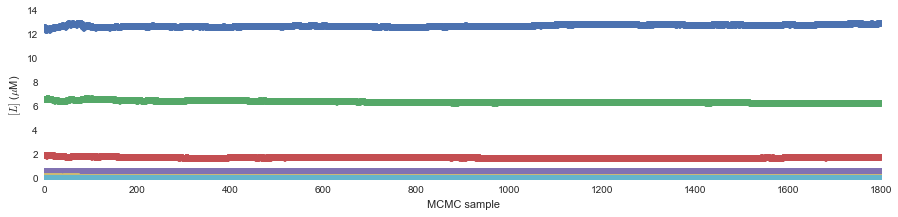

In [13]:
# Plot trace of true protein concentration.
rcParams['figure.figsize'] = [15, 3]
plot(mcmc.Ltrue.trace()*1e6, 'o');
xlabel('MCMC sample');
ylabel('$[L]$ ($\mu$M)');
print mcmc.Ltrue.trace().min()

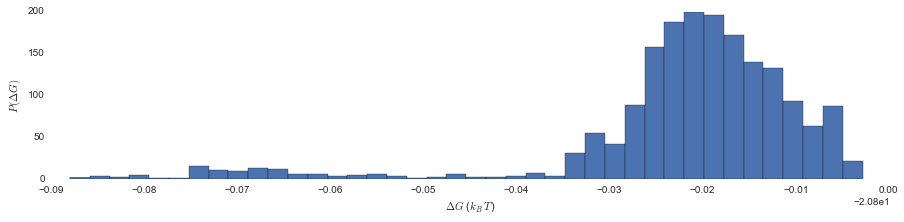

In [14]:
# Plot histogram of DeltaG.
rcParams['figure.figsize'] = [15, 3]
hist(mcmc.DeltaG.trace(), 40);
xlabel('$\Delta G$ ($k_B T$)');
ylabel('$P(\Delta G)$');

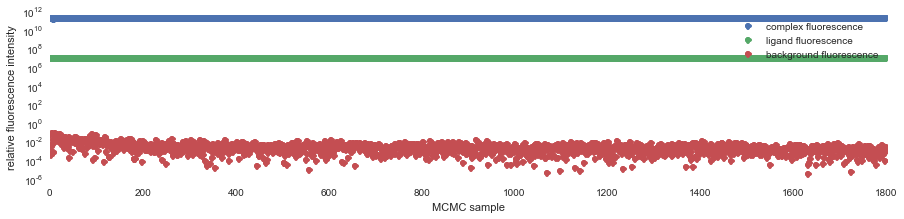

In [15]:
# Plot trace of intrinsic fluorescence parameters.
rcParams['figure.figsize'] = [15, 3]
semilogy(mcmc.F_PL.trace(), 'o', mcmc.F_L.trace(), 'o', mcmc.F_background.trace(), 'o');
legend(['complex fluorescence', 'ligand fluorescence', 'background fluorescence']);
xlabel('MCMC sample');
ylabel('relative fluorescence intensity');

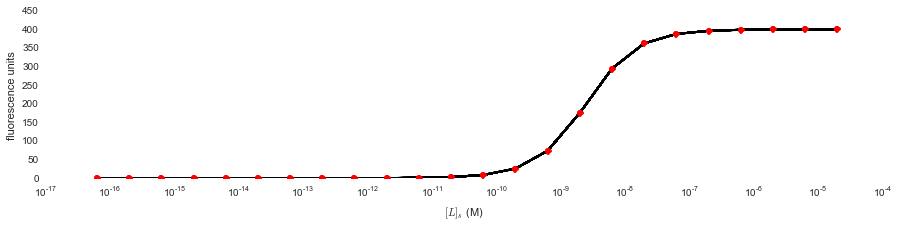

In [16]:
# Plot model fit.
rcParams['figure.figsize'] = [15, 3]
figure = pyplot.gcf() # get current figure
Fmodels = mcmc.Fmodel_i.trace()
clf();
hold(True)
for Fmodel in Fmodels:
    semilogx(Lstated, Fmodel, 'k-')
semilogx(Lstated, F_i, 'ro')
hold(False)
xlabel('$[L]_s$ (M)');
ylabel('fluorescence units');

###Did it work?

In [19]:
DeltaGMean = np.mean(mcmc.DeltaG.trace())
print DeltaGMean

-20.821911458


In [23]:
Kd_calc = np.exp(DeltaGMean)
print Kd_calc

9.06063741044e-10


In [24]:
Kd_real = 2e-9

In [28]:
off_by = np.abs(Kd_calc-Kd_real)
print off_by

1.09393625896e-09


#####Basically we modeled data for a Kd of 2 nM, and with Bayes even with ideal data, it still thought that the Kd was 0.9 nM.

###Can we get a better result just by improving our data?

Let's make a 'better' set of data.

In [95]:
def make_two_component_binding(Kd, Ptot, Ltot):
                   
    PL = 0.5 * ((Ptot + Ltot + Kd) - np.sqrt((Ptot + Ltot + Kd)**2 - 4*Ptot*Ltot))  # complex concentration (uM)
    P = Ptot - PL; # free protein concentration in sample cell after n injections (uM)                                                                                                                                                                                                                          
    L = Ltot - PL; # free ligand concentration in sample cell after n injections (uM)                                                                                                                                                                                                                           
    return [P, L, PL]

All we need to do make 'better' data is refine our Ligand range.

In [96]:
Lnew = 1.0e-7 / np.array([10**(float(i)/8.0) for i in range(24)]) 

In [97]:
[L, P, PL] = make_two_component_binding(2e-9,Ptot,Lnew)

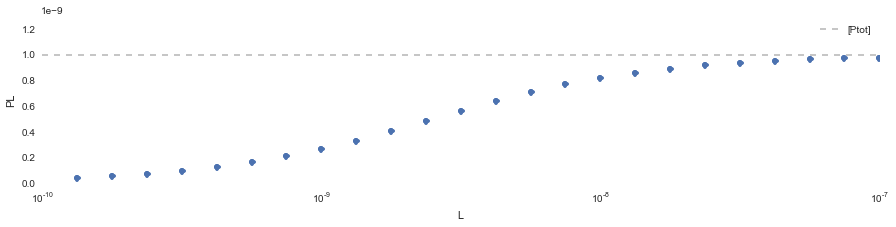

In [98]:
# y will be complex concentration
# x will be total ligand concentration
plt.semilogx(Lnew,PL, 'o')
plt.xlabel('L')
plt.ylabel('PL')
plt.ylim(0,1.3e-9)
plt.axhline(Ptot,color='0.75',linestyle='--',label='[Ptot]')
plt.legend()

Great! Now let's see how pymc does.

In [99]:
Lstated = np.ones([24],np.float64)*Lnew
F_i = np.ones([24],np.float64)*(400/1e-9)*PL

In [100]:
# Build model.
pymc_model = pymc.Model(make_model(Pstated, dPstated, Lstated, dLstated, F_i))

# Sample with MCMC
mcmc = pymc.MCMC(pymc_model, db='ram', name='Sampler', verbose=True)
mcmc.sample(iter=100000, burn=10000, thin=50, progress_bar=False)

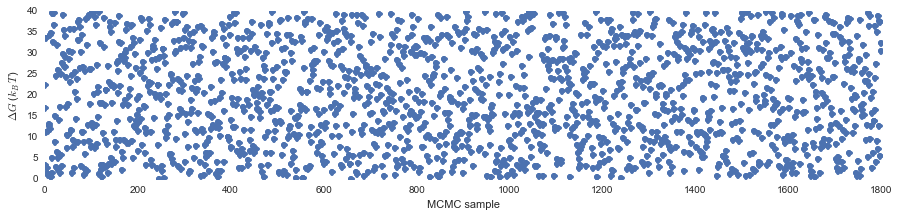

In [101]:
# Plot trace of DeltaG.
rcParams['figure.figsize'] = [15, 3]
plot(mcmc.DeltaG.trace(), 'o');
xlabel('MCMC sample');
ylabel('$\Delta G$ ($k_B T$)');

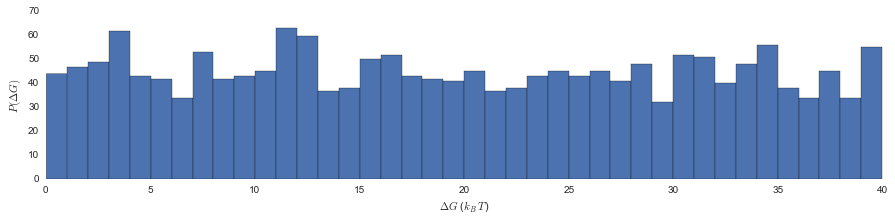

In [102]:
# Plot histogram of DeltaG.
rcParams['figure.figsize'] = [15, 3]
hist(mcmc.DeltaG.trace(), 40);
xlabel('$\Delta G$ ($k_B T$)');
ylabel('$P(\Delta G)$');

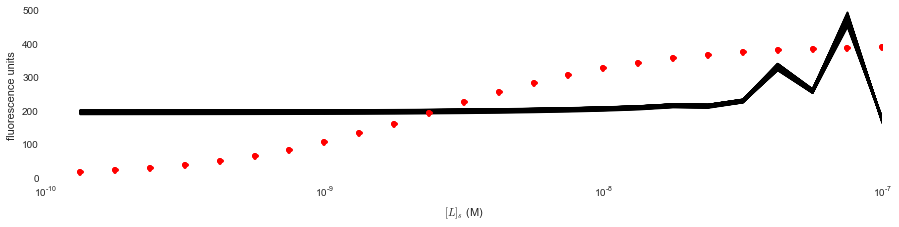

In [103]:
# Plot model fit.
rcParams['figure.figsize'] = [15, 3]
figure = pyplot.gcf() # get current figure
Fmodels = mcmc.Fmodel_i.trace()
clf();
hold(True)
for Fmodel in Fmodels:
    semilogx(Lstated, Fmodel, 'k-')
semilogx(Lstated, F_i, 'ro')
hold(False)
xlabel('$[L]_s$ (M)');
ylabel('fluorescence units');

Hmmmmm.